🍷 와인 품질 예측 데이터 분석 및 머신러닝 모델링
본 프로젝트는 와인의 화학적 성분 데이터를 활용하여 와인의 품질 등급을 예측하는 분류 모델을 구축하는 것을 목표로 합니다. 데이터 탐색적 분석(EDA)부터 전처리, 모델 최적화 과정을 차례대로 진행합니다.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [3]:
# 1. 데이터 로드: 와인 품질 데이터셋 불러오기
wine_df = pd.read_csv('./data/WineQT.csv')
print(f"최초 데이터 크기: {wine_df.shape}")

# 2. 분석에 필요 없는 Id 컬럼 제거: 개별 샘플의 식별자(Id)는 학습에 불필요하므로 삭제
if 'Id' in wine_df.columns:
    wine_df = wine_df.drop('Id', axis=1)
print(f"Id 제거 후 크기: {wine_df.shape}")

# 3. 특정 Quality(3, 4, 8) 데이터 삭제: 샘플 수가 너무 적어 학습에 방해가 되는 등급 제거
# target_quality = [3, 4, 8]
# wine_df = wine_df[~wine_df['quality'].isin(target_quality)]

# 삭제 후 결과 확인: 5, 6, 7 등급 위주로 구성됨을 확인
# print(f"Quality(3, 4, 8) 삭제 후 크기: {wine_df.shape}")
# print(f"남은 품질 등급: {wine_df['quality'].unique()}")

wine_df.head()

최초 데이터 크기: (1143, 13)
Id 제거 후 크기: (1143, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


데이터 속성(Features) 설명

와인의 품질을 결정하는 주요 독립 변수:

1 - 고정 산도, 2 - 휘발성 산도, 3 - 구연산, 4 - 잔류당

5 - 염화물, 6 - 이산화황이 없는, 7 - 총 이산화황, 8 - 밀도

9 - pH, 10 - 황산염, 11 - 알코올, 12 - 품질(Target)

In [4]:
# 퀄리티를 3단계(Low, Medium, High)로 나누는 함수 정의
# 6단계로 세분화 시 데이터 불균형으로 인한 학습 저하를 막기 위함
def quality_group(q):
    if q <= 5:
        return 0   # low (5점 대상)
    elif q <= 6:
        return 1   # medium (6점 대상)
    else:
        return 2   # high (7점 대상)

# quality_group 컬럼 새로 생성
wine_df['quality_group'] = wine_df['quality'].apply(quality_group)

In [5]:
# 입력 데이터(X)에서 원본 quality와 새로 만든 group 컬럼 제외
X = wine_df.drop(columns=['quality', 'quality_group']).to_numpy()
y = wine_df['quality_group'].to_numpy() # 타겟 데이터로 그룹화된 등급 사용

print(X.shape, y.shape)

# 학습용과 테스트용 데이터 8:2 분할 (stratify를 통해 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 결측치 존재 여부 및 컬럼별 데이터 타입(Dtype) 최종 확인
print(wine_df.info())

(1143, 11) (1143,)
(914, 11) (914,)
(229, 11) (229,)
<class 'pandas.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  quality_group         1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


탐색적 데이터 분석 (EDA): 변수 간 관계 파악

주요 성분이 와인 품질에 어떤 영향을 주는지 시각화를 통해 확인해 봅니다

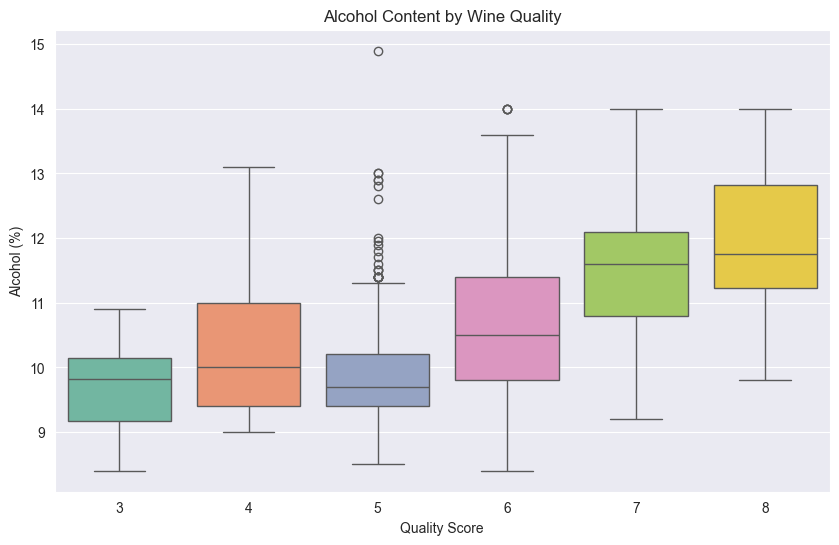

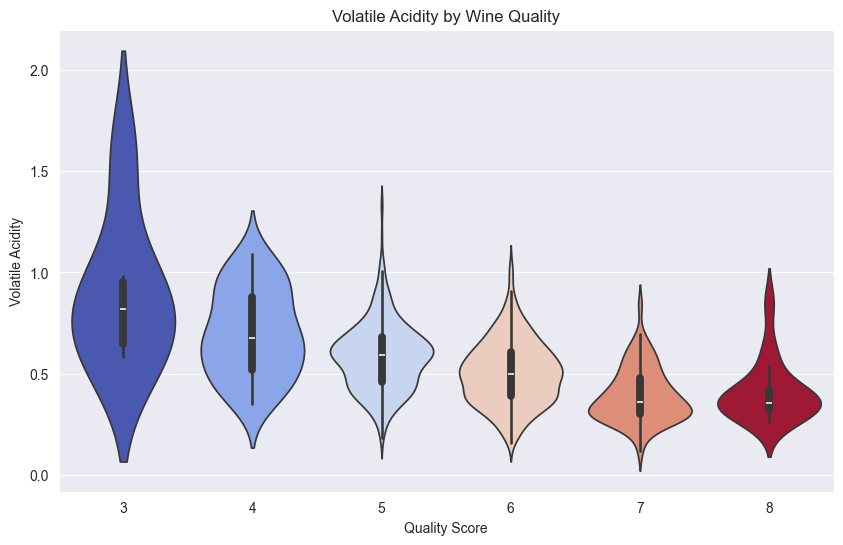

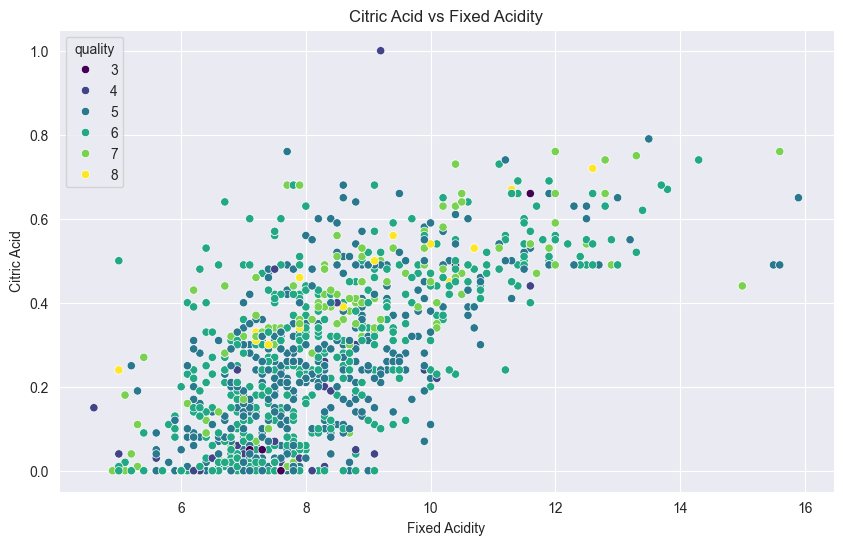

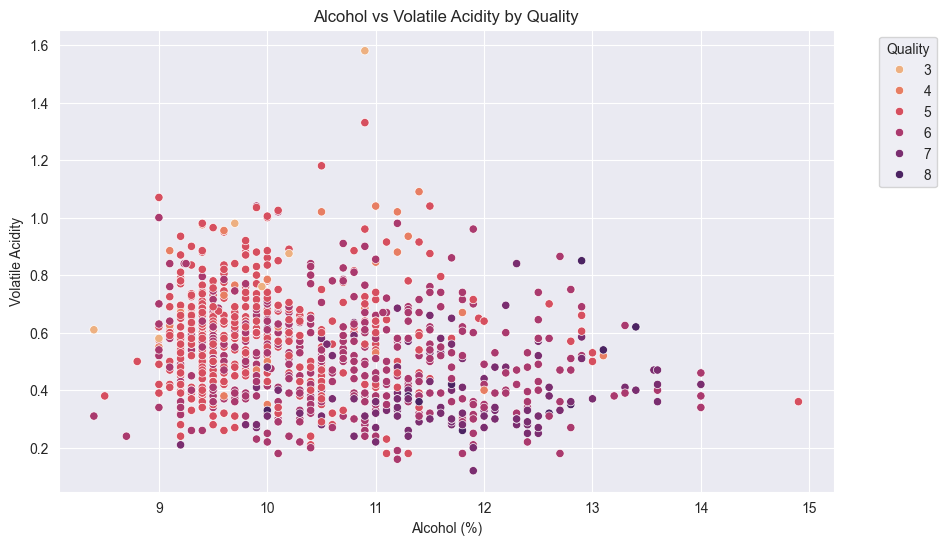

In [14]:
# 알코올 도수가 품질 점수에 미치는 영향 분석
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', data=wine_df, hue='quality', palette='Set2', legend=False)
plt.title('Alcohol Content by Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Alcohol (%)')
plt.show()
# 품질 점수가 높아질수록 알코올 도수의 중앙값이 상승하는 경향이 있는지 확인.

# ----------------------------------------------------------------------#

# 휘발성 산도(식초 맛)가 품질에 미치는 부정적 영향 분석
plt.figure(figsize=(10, 6))
sns.violinplot(x='quality', y='volatile acidity', data=wine_df, hue='quality', palette='coolwarm', legend=False)
plt.title('Volatile Acidity by Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Volatile Acidity')
plt.show()
# 산도가 너무 높으면 와인이 상한 맛을 내기 때문에 품질이 급격히 떨어진다.

# ----------------------------------------------------------------------#

# 두 산성 성분 간의 선형 관계 분석 / 데이터의 일관성 확인(참고용)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='citric acid', hue='quality', data=wine_df, palette='viridis')
plt.title('Citric Acid vs Fixed Acidity')
plt.xlabel('Fixed Acidity')
plt.ylabel('Citric Acid')
plt.show()
# 고정 산도가 높을수록 구연산 함량도 높아지는 양의 선형 관계가 있는지 확인.
# 데이터의 신뢰성 검증, 성분 간의 중복성 확인.(고정 산도에는 구연산도 포함이 된다.)
# 의미있는 산점도는 아니다. 알코올과 휘발성 산도 간의 산점도를 나타내는 것이 효과적이다.
# ----------------------------------------------------------------------#

# 품질에 가장 큰 영향을 미치는 두 변수 간의 관계 분석 (핵심)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="alcohol", y="volatile acidity", hue="quality", data=wine_df, palette="flare")
plt.title("Alcohol vs Volatile Acidity by Quality")
plt.xlabel("Alcohol (%)")
plt.ylabel("Volatile Acidity")
plt.legend(title="Quality", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()
# 고품질 와인일수록 알코올은 높고 휘발성 산도는 낮은 경향(우하향 분포)이 있는지 확인.


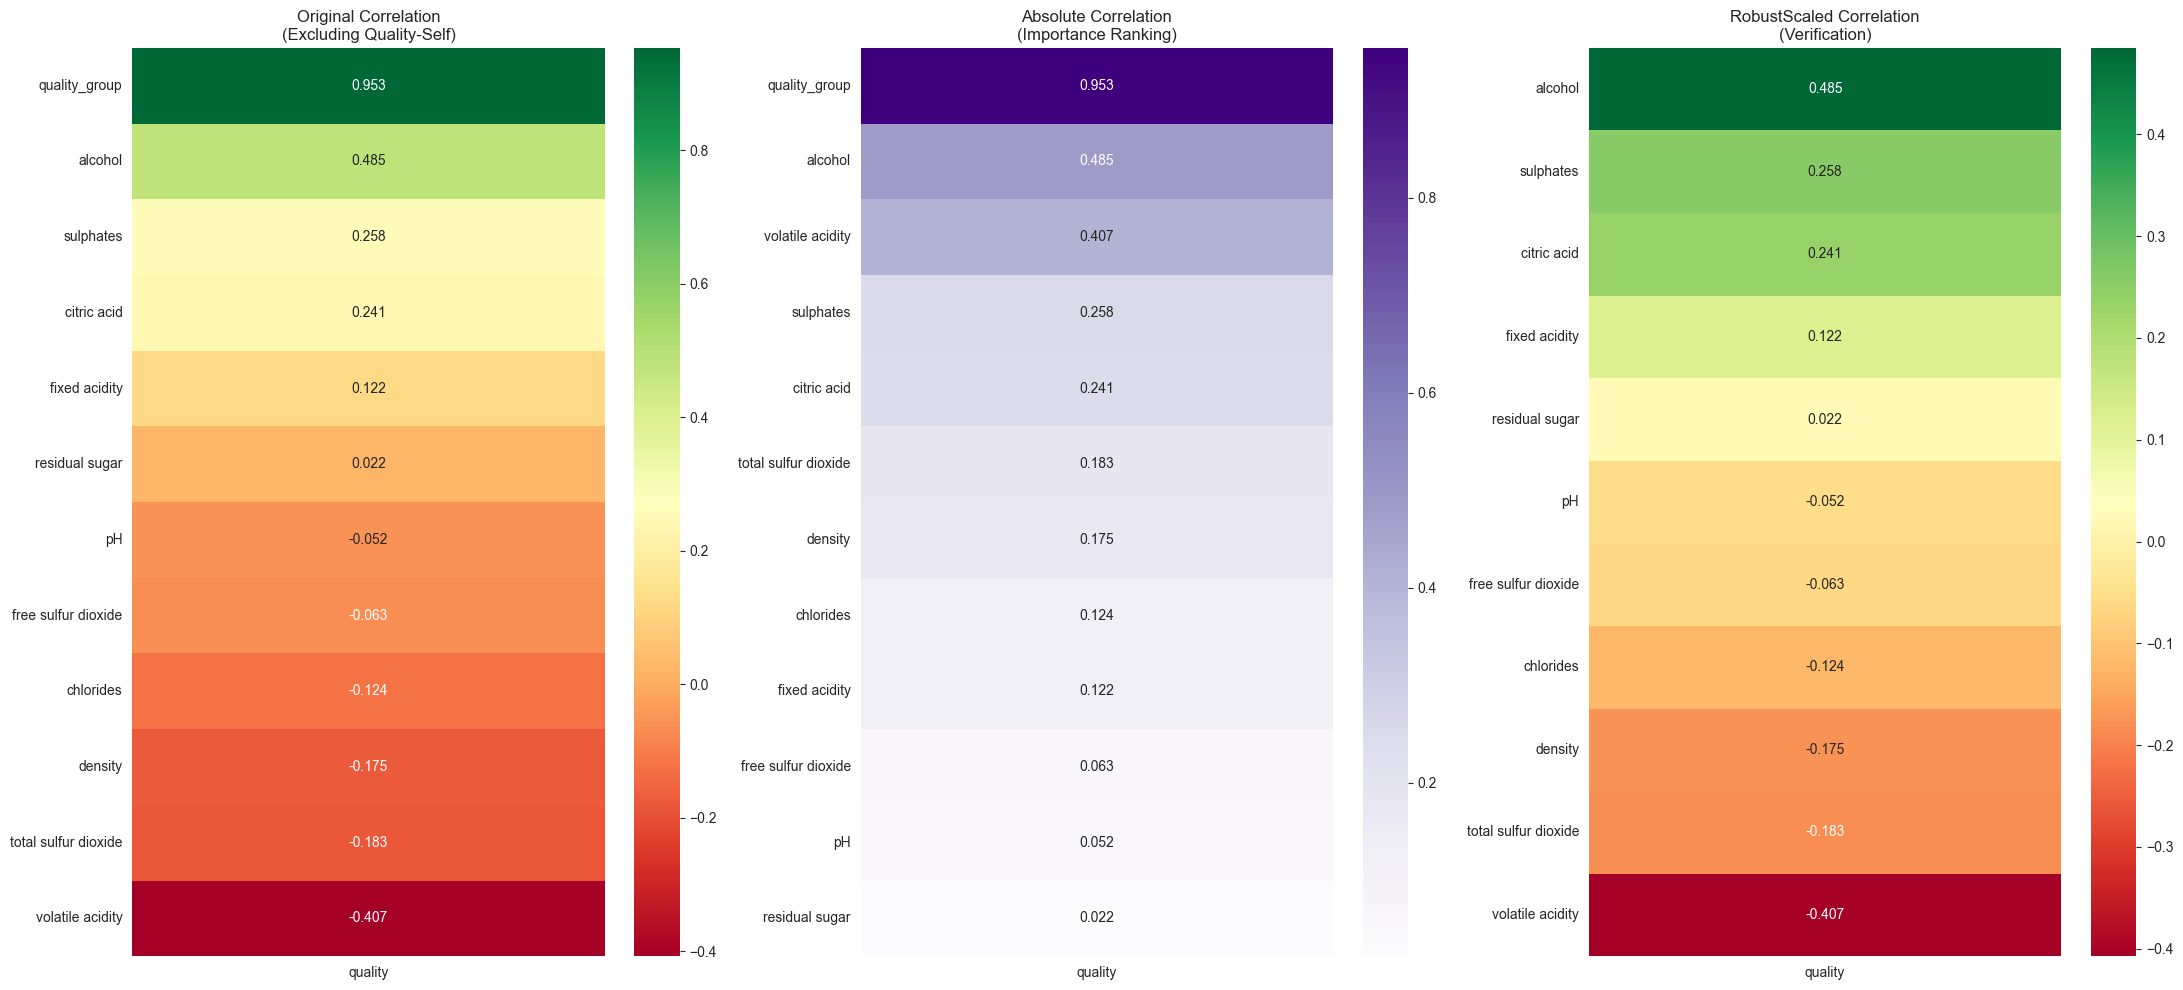

In [7]:
# 1. 원본 데이터 상관관계 (quality 자기 자신 제외)
corr_original = wine_df.corr()[["quality"]].drop(index="quality", errors="ignore").sort_values(by="quality", ascending=False)

# 2. 상관관계 절대값 (quality 자기 자신 제외)
corr_abs = wine_df.corr()[["quality"]].drop(index="quality", errors="ignore").abs().sort_values(by="quality", ascending=False)

# 3. RobustScaler 적용 후 상관관계 (quality 자기 자신 제외)
scaler_robust = RobustScaler()
features = wine_df.drop(columns=["quality", "quality_group", "quality_binary"], errors="ignore")
scaled_data = scaler_robust.fit_transform(features)
scaled_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_df["quality"] = wine_df["quality"].values
corr_robust = scaled_df.corr()[["quality"]].drop(index="quality", errors="ignore").sort_values(by="quality", ascending=False)

# 시각화 (1행 3열 비교)
fig, ax = plt.subplots(1, 3, figsize=(22, 10))

# [0] 원본 히트맵
sns.heatmap(corr_original, annot=True, cmap="RdYlGn", fmt=".3f", ax=ax[0])
ax[0].set_title("Original Correlation\n(Excluding Quality-Self)")

# [1] 절대값 히트맵
sns.heatmap(corr_abs, annot=True, cmap="Purples", fmt=".3f", ax=ax[1])
ax[1].set_title("Absolute Correlation\n(Importance Ranking)")

# [2] RobustScaler 히트맵
sns.heatmap(corr_robust, annot=True, cmap="RdYlGn", fmt=".3f", ax=ax[2])
ax[2].set_title("RobustScaled Correlation\n(Verification)")

plt.tight_layout()
plt.show()

모델 최적화: 그리드 서치(GridSearch)

RandomForest 모델의 성능을 극대화하기 위해 하이퍼파라미터 튜닝을 진행합니다.

In [8]:
# 3단계 분류 그룹화 전, 원본 데이터의 등급별 샘플 수 파악
wine_df['quality'].value_counts()

# 표준화(StandardScaler): 평균 0, 표준편차 1로 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 새롭게 정의한 3단계 등급(0, 1, 2)의 샘플 수 확인
wine_df['quality_group'].value_counts()

# RandomForest의 최적 파라미터 조합 설정
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'n_estimators': [10, 50, 100]
}

# 5-폴드 교차 검증을 통해 최적의 모델 찾기
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# 교차 검증 상세 결과를 데이터프레임으로 저장
cv_results_df = pd.DataFrame(grid.cv_results_)

# 각 조합별 성능(mean_test_score 등) 확인
cv_results_df = pd.DataFrame(grid.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017605,0.008518,0.001165,0.000404,None,10,"{'max_depth': None, 'n_estimators': 10}",0.672131,0.672131,0.666667,0.650273,0.620879,0.656416,0.019492,7
1,0.080777,0.012286,0.005452,0.002889,None,50,"{'max_depth': None, 'n_estimators': 50}",0.666667,0.661202,0.721311,0.644809,0.642857,0.667369,0.028489,5
2,0.122807,0.008726,0.005267,0.000229,None,100,"{'max_depth': None, 'n_estimators': 100}",0.688525,0.683060,0.710383,0.672131,0.637363,0.678292,0.023960,2
3,0.009255,0.001047,0.000696,0.000037,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.628415,0.661202,0.644809,0.639344,0.593407,0.633435,0.022640,11
4,0.044819,0.001353,0.003363,0.002088,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.644809,0.639344,0.650273,0.644809,0.637363,0.643320,0.004562,10
5,0.197851,0.034552,0.017167,0.009869,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.661202,0.655738,0.677596,0.628415,0.604396,0.645469,0.025934,9
6,0.012174,0.000465,0.001007,0.000427,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.612022,0.650273,0.639344,0.628415,0.626374,0.631286,0.012876,12
7,0.097418,0.021328,0.003572,0.000462,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.650273,0.693989,0.721311,0.622951,0.664835,0.670672,0.034163,4
8,0.161891,0.030960,0.006230,0.001307,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.688525,0.666667,0.710383,0.655738,0.642857,0.672834,0.024021,3
9,0.013745,0.001302,0.001120,0.000246,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.672131,0.672131,0.688525,0.639344,0.604396,0.655305,0.030054,8


In [9]:
# 1️⃣ 이진 라벨 생성: 6점 이상을 1(Good), 미만을 0(Bad)으로 설정
wine_df["quality_binary"] = (wine_df["quality"] >= 6).astype(int)

# 2️⃣ X, y 재정의: 품질 점수 관련 컬럼을 제외하고 모델 입력 정의
X = wine_df.drop(columns=["quality", "quality_binary", "quality_group"]).values
y = wine_df["quality_binary"].values

# 3️⃣ 이진 분류용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ MinMaxScaler 적용: 데이터 범위를 0~1 사이로 정규화
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ 이진 분류 모델 학습 (최적 깊이 15, 트리 50개 설정)
rf = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

# 예측 수행 및 평가지표(Precision, Recall, F1-score) 출력
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.81      0.85      0.83       124

    accuracy                           0.81       229
   macro avg       0.81      0.81      0.81       229
weighted avg       0.81      0.81      0.81       229



In [10]:
# -----------------------------
# 1. 기본 모델 학습 및 평가
# -----------------------------
rf_default = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf_default.fit(X_train_scaled, y_train)
y_pred_default = rf_default.predict(X_test_scaled)

print("===== Default RandomForest =====")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

# -----------------------------
# 2. class_weight='balanced' 적용 모델: 부족한 클래스에 가중치를 주어 학습 보완
# -----------------------------
rf_balanced = RandomForestClassifier(
    max_depth=15,
    n_estimators=50,
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(X_train_scaled, y_train)
y_pred_balanced = rf_balanced.predict(X_test_scaled)

print("===== Balanced RandomForest =====")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

===== Default RandomForest =====
Accuracy: 0.8122270742358079
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.81      0.85      0.83       124

    accuracy                           0.81       229
   macro avg       0.81      0.81      0.81       229
weighted avg       0.81      0.81      0.81       229

===== Balanced RandomForest =====
Accuracy: 0.7947598253275109
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       105
           1       0.79      0.85      0.82       124

    accuracy                           0.79       229
   macro avg       0.80      0.79      0.79       229
weighted avg       0.80      0.79      0.79       229



클래스 불균형 문제를 해결하기 위해 class_weight='balanced'를 적용했으나, 소수 클래스의 샘플 수가 매우 적어 성능 개선 효과는 미미하였다.

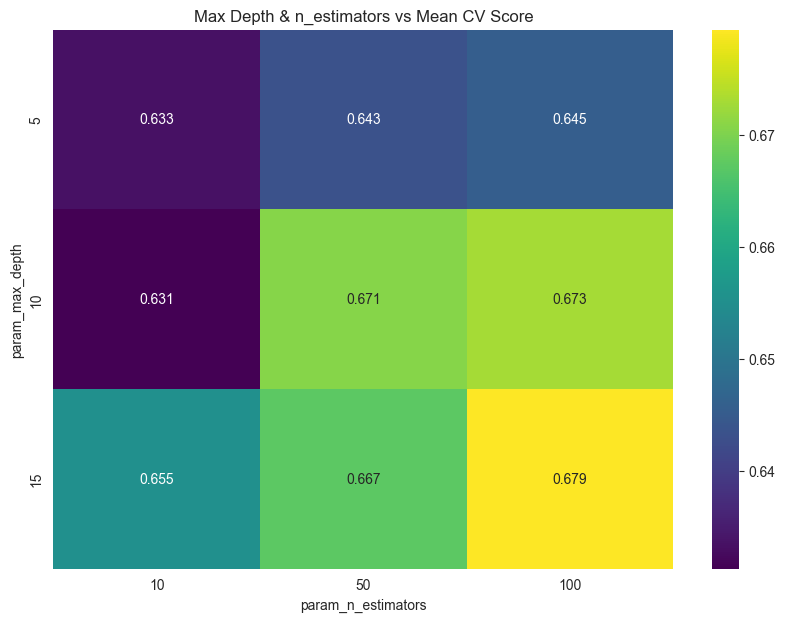

Best Params: {'max_depth': 15, 'n_estimators': 100}
Best CV Score: 0.6793971056266138


In [11]:
# 그리드 서치 결과를 피벗 테이블로 변환하여 성능 흐름 시각화
cv_pivot = cv_results_df.pivot_table(
    columns='param_n_estimators',
    index='param_max_depth',
    values='mean_test_score',
)

# 히트맵 그리기: 트리 깊이와 개수가 정확도에 미치는 영향 파악
plt.figure(figsize=(10, 7))
sns.heatmap(cv_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Max Depth & n_estimators vs Mean CV Score")
plt.show()

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

RandomForest는 여러 트리의 평균을 사용하기 때문에 깊은 트리에서도 과적합이 완화되며, max_depth=15, n_estimators=50 조합에서 가장 높은 평균 교차검증 정확도(0.857)를 보였다.

In [12]:
# 그리드 서치에서 발견된 가장 좋은 성능의 모델 객체 저장
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'max_depth': 15, 'n_estimators': 100}
Best CV Score: 0.6793971056266138


Best Params: {'max_depth': 15, 'n_estimators': 100}
Best CV Score: 0.6793971056266138
Unique labels in Test Set: [0 1]

===== Final Model Performance =====
Accuracy: 0.8122270742358079
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.81      0.85      0.83       124

    accuracy                           0.81       229
   macro avg       0.81      0.81      0.81       229
weighted avg       0.81      0.81      0.81       229



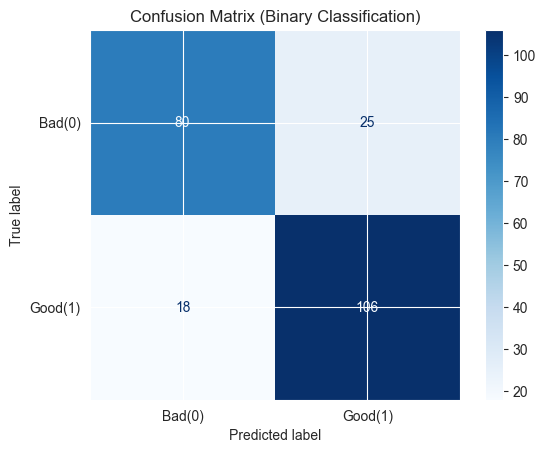

In [13]:
# 1. 이전 단계에서 찾은 최적의 모델과 파라미터 확인
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# 2. 이진 분류를 위한 최종 데이터 준비 및 검증
# (이미 Cell 8~11에서 분할과 스케일링이 완료된 X_train_scaled, y_train, X_test_scaled를 그대로 사용)
print("Unique labels in Test Set:", np.unique(y_test)) # 테스트 셋의 라벨(0: Bad, 1: Good) 확인

# 3. 최종 모델 학습 (그리드 서치 결과인 max_depth=15, n_estimators=50 적용)
rf_final = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf_final.fit(X_train_scaled, y_train)

# 4. 최종 예측 및 성능 지표 출력
y_pred = rf_final.predict(X_test_scaled)
print("\n===== Final Model Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 5. 혼동 행렬 시각화: 모델이 어느 등급을 헷갈려 하는지 시각적으로 파악
# Precision(정밀도)과 Recall(재현율)의 트레이드오프
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad(0)', 'Good(1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Binary Classification)")
plt.show()

와인 품질 점수를 세 단계로 예측하는 것은 어려웠으나, 이를 2단계(좋음/보통) 이진분류로 재구성한 결과 정확도와 클래스 균형 성능이 크게 향상되었다.